## Upload and config the image

In [129]:
IMAGE_FILE = "anh.jpg"
IMAGE_FILE_2 = "image.jpeg"
GRAYSCALE_IMAGE_FILE = "gs_anh.jpg"

## Preprocess

In [79]:
# Convert img to grayscale using GPU from scratch

from numba import cuda
import numpy as np
import matplotlib.pyplot as plt

@cuda.jit
def grayscale(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  if tidx >= len(src):
    return
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx] = g

def grayscale_gpu(image_file, blockSize=64):
  img = plt.imread(image_file)
  imageHeight, imageWidth, _ = img.shape
  pixelCount = imageWidth * imageHeight
  gridSize = (pixelCount + blockSize - 1) // blockSize
  flatSrc = np.reshape(img, (pixelCount, 3))

  devSrc = cuda.to_device(flatSrc)
  devDst = cuda.device_array((pixelCount,), np.uint8)
  grayscale[gridSize, blockSize](devSrc, devDst)
  hostDst = devDst.copy_to_host()

  img = hostDst.reshape((imageHeight, imageWidth, 1))
  return img


In [83]:
# Convert image to grayscale using lib.
from PIL import Image

image = Image.open(IMAGE_FILE).convert("L")
image.save(GRAYSCALE_IMAGE_FILE)

## Visualize the image

In [86]:
import matplotlib.pyplot as plt

def show_image(image, title=None, vmax=255):
  if isinstance(image, str):
    image = plt.imread(image)

  height, width = image.shape[0], image.shape[1]
  print(f"Size of image: {width} x {height} - {height * width} pixels")

  plt.imshow(image, cmap='gray', vmin=0, vmax=vmax)
  plt.axis('off')
  plt.title(title, fontweight ="bold")
  plt.show()

Size of image: 256 x 256 - 65536 pixels


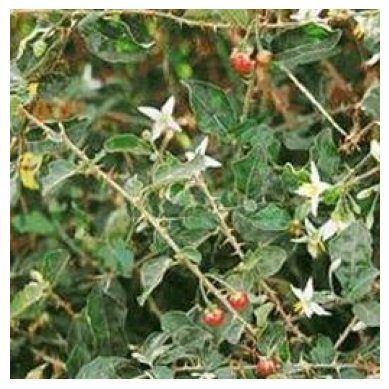

Size of image: 256 x 256 - 65536 pixels


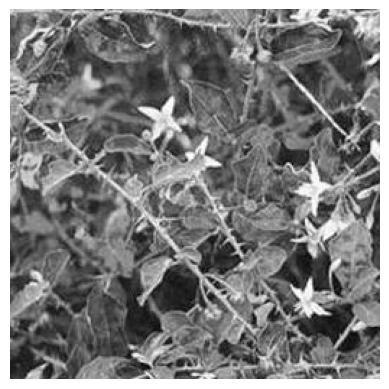

In [87]:
show_image(IMAGE_FILE)
show_image(GRAYSCALE_IMAGE_FILE)

## Extra 6a: Binarization

In [88]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def binarization(src, dst, threshold):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidy >= len(src) or tidx >= len(src[0]):
    return

  dst[tidy][tidx] = 1 if src[tidy][tidx] > threshold else 0


def grayscale_image_binarization(image_file, blockSize=(32, 32), threshold=128):
  img = plt.imread(image_file)
  imageHeight, imageWidth = img.shape
  gridSize = (
    (imageHeight + blockSize[0] - 1) // blockSize[0],
    (imageWidth + blockSize[1] - 1) // blockSize[1]
  )

  print(f"Do binarization image by gpu, blockSize={blockSize} ...")

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((imageHeight, imageWidth), np.uint8)
  binarization[gridSize, blockSize](devSrc, devDst, threshold)
  img = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  return img, total_time


Do binarization image by gpu, blockSize=(32, 32) ...
It took 0.12771058082580566 seconds to finish.
Size of image: 256 x 256 - 65536 pixels


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


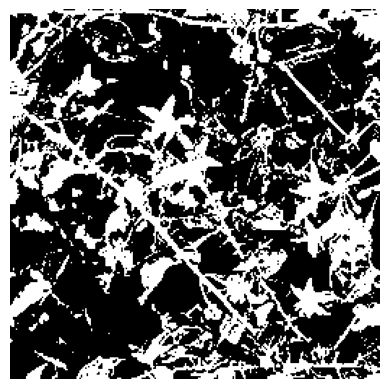

In [89]:
out_img, _ = grayscale_image_binarization(GRAYSCALE_IMAGE_FILE, (32, 32), threshold=128)

show_image(out_img, vmax=1)

## Extra 6b: Brightness control

Do brightness image by gpu, blockSize=(32, 32) ...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


It took 0.3309133052825928 seconds to finish.
Size of image: 256 x 256 - 65536 pixels


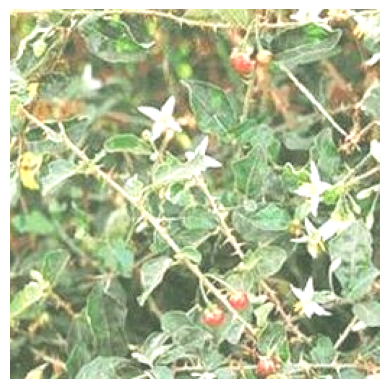

In [97]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def brightness(src, dst, value):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  for i in range(3):
    if tidy >= len(src) or tidx >= len(src[0]):
      return

    g = src[tidy][tidx][i] + value
    g = 255 if g > 255 else 0 if g < 0 else g
    dst[tidy][tidx][i] = g


def image_brightness(image_file, blockSize=(32, 32), value=16):
  img = plt.imread(image_file)
  imageHeight, imageWidth = img.shape[0], img.shape[1]
  gridSize = (
    (imageHeight + blockSize[0] - 1) // blockSize[0],
    (imageWidth + blockSize[1] - 1) // blockSize[1]
  )

  print(f"Do brightness image by gpu, blockSize={blockSize} ...")

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  brightness[gridSize, blockSize](devSrc, devDst, value)
  img = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  return img, total_time


out_img, _ = image_brightness(IMAGE_FILE, (32, 32), value=64)
show_image(out_img)

## Extra 6c: Blending images

(256, 256, 3) (316, 474, 3)
Do blend image by gpu, blockSize=(32, 32) ...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


It took 0.28946805000305176 seconds to finish.
Size of image: 256 x 256 - 65536 pixels


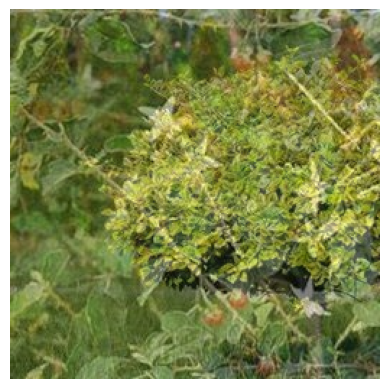

In [149]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def blend(src1, src2, dst, weight):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidy >= len(src1) or tidx >= len(src1[0]):
      return

  for i in range(3):
    g = src1[tidy][tidx][i] * weight + src2[tidy][tidx][i] * (1 - weight)
    g = 255 if g > 255 else 0 if g < 0 else int(g)
    dst[tidy][tidx][i] = g


def image_blend(image_file1, image_file2, blockSize=(32, 32), weight=0.5):
  img1 = plt.imread(image_file1)
  img2 = plt.imread(image_file2)

  # convert grayscale to 3-channels image
  if len(img1.shape) == 2 or img1.shape[2] == 1:
    img1 = np.stack((img1,)*3, axis=-1)
  if len(img2.shape) == 2 or img2.shape[2] == 1:
    img2 = np.stack((img2,)*3, axis=-1)

  # assert img1.shape == img2.shape, "Image size must be the same!"

  imageHeight, imageWidth = img1.shape[0], img1.shape[1]
  print(img1.shape, img2.shape)

  gridSize = (
    (imageHeight + blockSize[0] - 1) // blockSize[0],
    (imageWidth + blockSize[1] - 1) // blockSize[1]
  )

  print(f"Do blend image by gpu, blockSize={blockSize} ...")

  start_t = time.time()

  devSrc1 = cuda.to_device(img1)
  devSrc2 = cuda.to_device(img2)
  devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  blend[gridSize, blockSize](devSrc1, devSrc2, devDst, weight)
  img = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  return img, total_time


out_img, _ = image_blend(IMAGE_FILE, IMAGE_FILE_2, (32, 32), weight=0.5)
show_image(out_img)

## Experiment with diﬀerent 2D block size values

Do binarization image by gpu, blockSize=(8, 8) ...
It took 0.0015246868133544922 seconds to finish.
Do brightness image by gpu, blockSize=(8, 8) ...
It took 0.0014500617980957031 seconds to finish.
(256, 256, 3) (316, 474, 3)
Do blend image by gpu, blockSize=(8, 8) ...
It took 0.0016210079193115234 seconds to finish.
Do binarization image by gpu, blockSize=(8, 8) ...
It took 0.0012700557708740234 seconds to finish.
Do brightness image by gpu, blockSize=(8, 8) ...
It took 0.0013327598571777344 seconds to finish.
(256, 256, 3) (316, 474, 3)
Do blend image by gpu, blockSize=(8, 8) ...
It took 0.002933979034423828 seconds to finish.
Do binarization image by gpu, blockSize=(16, 16) ...
It took 0.0012753009796142578 seconds to finish.
Do brightness image by gpu, blockSize=(16, 16) ...
It took 0.0013606548309326172 seconds to finish.
(256, 256, 3) (316, 474, 3)
Do blend image by gpu, blockSize=(16, 16) ...
It took 0.002748727798461914 seconds to finish.
Do binarization image by gpu, blockSize

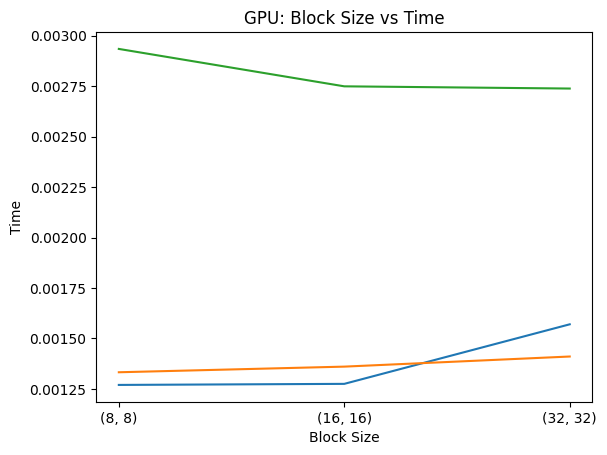

In [138]:
import matplotlib.pyplot as plt

# Process in 2D grid
block_sizes = [
   (8, 8), (8, 8), (16, 16), (32, 32),
]

binarization_process_times = []
brightness_process_times = []
blend_process_times = []

for block_size in block_sizes:
  _, total_time = grayscale_image_binarization(GRAYSCALE_IMAGE_FILE, block_size)
  binarization_process_times.append(total_time)

  _, total_time = image_brightness(IMAGE_FILE, block_size)
  brightness_process_times.append(total_time)

  _, total_time = image_blend(IMAGE_FILE, IMAGE_FILE_2, block_size)
  blend_process_times.append(total_time)

# Plot a graph of block size vs time
x_labels = [str(dim) for dim in block_sizes[1:]]
plt.plot(x_labels, binarization_process_times[1:], label="binarization")
plt.plot(x_labels, brightness_process_times[1:], label="brightness")
plt.plot(x_labels, blend_process_times[1:], label="blend")

plt.title('GPU: Block Size vs Time')
plt.xlabel('Block Size')
plt.ylabel('Time')
plt.show()
